In [53]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19,densenet121
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
from DatasetGenerator import DatasetGenerator
from torch.utils.data import DataLoader
import os

In [40]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet121 network
        self.densenet = densenet121(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = nn.Sequential(nn.Linear(1024, 1), nn.Sigmoid())
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1024))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [63]:
name = []
MON_TB = open('/home/stevenlai/Desktop/chexnet/Full_set/dataset/MON_TB.txt','r')
for line in MON_TB:
    name.append(line.split('.')[0].split('/')[1])

filenames = []
for filename in os.listdir('/home/stevenlai/Desktop/chexnet/Full_set/heatmap/MonClinicalReadings/'):
    filenames.append(filename.split('.')[0])

['MCUCXR_0254_1', 'MCUCXR_0390_1', 'MCUCXR_0162_1', 'MCUCXR_0362_1', 'MCUCXR_0223_1', 'MCUCXR_0264_1', 'MCUCXR_0144_1', 'MCUCXR_0348_1', 'MCUCXR_0140_1', 'MCUCXR_0383_1', 'MCUCXR_0313_1', 'MCUCXR_0301_1']


['MCUCXR_0030_0',
 'MCUCXR_0045_0',
 'MCUCXR_0254_1',
 'MCUCXR_0023_0',
 'MCUCXR_0053_0',
 'MCUCXR_0029_0',
 'MCUCXR_0080_0',
 'MCUCXR_0068_0',
 'MCUCXR_0011_0',
 'MCUCXR_0313_1',
 'MCUCXR_0362_1',
 'MCUCXR_0203_1',
 'MCUCXR_0040_0',
 'MCUCXR_0075_0',
 'MCUCXR_0094_0',
 'MCUCXR_0294_1',
 'MCUCXR_0004_0',
 'MCUCXR_0104_1',
 'MCUCXR_0282_1',
 'MCUCXR_0228_1',
 'MCUCXR_0103_0',
 'MCUCXR_0095_0',
 'MCUCXR_0126_1',
 'MCUCXR_0101_0',
 'MCUCXR_0196_1',
 'MCUCXR_0142_1',
 'MCUCXR_0060_0',
 'MCUCXR_0188_1',
 'MCUCXR_0251_1',
 'MCUCXR_0223_1',
 'MCUCXR_0348_1',
 'MCUCXR_0258_1',
 'MCUCXR_0354_1',
 'MCUCXR_0289_1',
 'MCUCXR_0194_1',
 'MCUCXR_0144_1',
 'MCUCXR_0140_1',
 'MCUCXR_0046_0',
 'MCUCXR_0173_1',
 'MCUCXR_0035_0',
 'MCUCXR_0047_0',
 'MCUCXR_0048_0',
 'MCUCXR_0090_0',
 'MCUCXR_0102_0',
 'MCUCXR_0028_0',
 'MCUCXR_0372_1',
 'MCUCXR_0195_1',
 'MCUCXR_0218_1',
 'MCUCXR_0015_0',
 'MCUCXR_0141_1',
 'MCUCXR_0041_0',
 'MCUCXR_0311_1',
 'MCUCXR_0019_0',
 'MCUCXR_0369_1',
 'MCUCXR_0016_0',
 'MCUCXR_0

datasetVal: 12
stable inactive scars in RUL; post treatment for abscillary TB



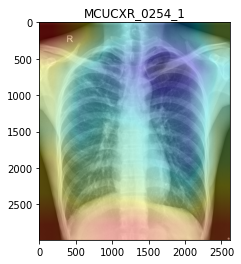

Rt apical scarring. LUL scars and some infiltrates as well; findings consistent with TB; ?active



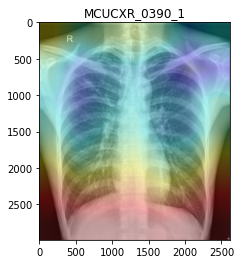

RUL apical fibrotic disease with some calcifications; extensive irregular infiltrates in left lung with a large area of cavitation/ findings consistent with old inactive disease in RL and new active TB in LL. On the lordotic view, in the rt apex a large thin walled cavity is visible, making active disease in the area likely as well.



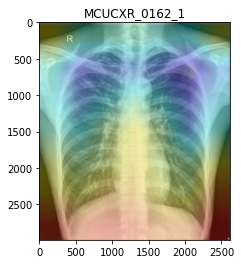

rt pleural effusion with some nodular infiltrate in rt lower lung; there are findings also of previous cardiac surgery; suspicious for active TB.



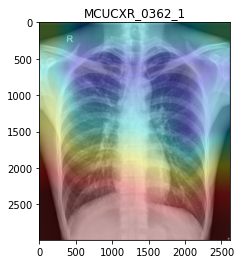

improving infiltrate in LUL



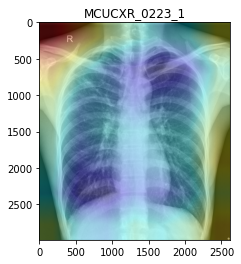

active TB; cavitary infiltrarte LUL; non-consolidated;



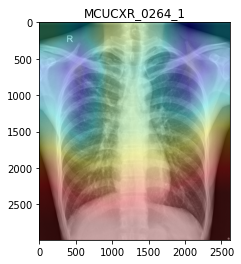

smear positive, active TB LUL apex



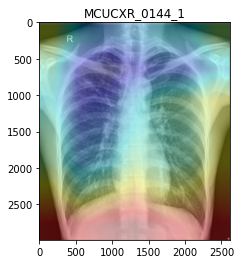

scoliosis to the left with some scarring in LLL and over the left apex; calcified granuloma in the rt lung. could be related to old TB.



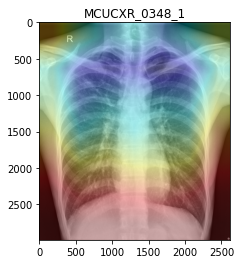

small LUL calcified granuloma; pt on rx for culture positive psoas abscess with abdominal lymphadenopathy since 6M



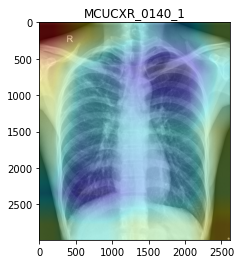

calcified granuloma LUL behind 4th rib anterior



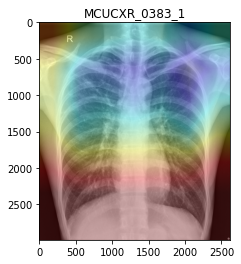

improvements. LUL cavity has closed.



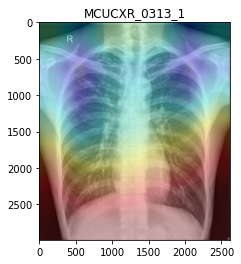

persistent rt pleural peel with some interval improvement with focal atelectasis in rt lung; anterior wedging of T5, T6 with loss of intervertebral disc space. Findings consistent with h/o spinal TB and pleural TB. Currently on Rx.



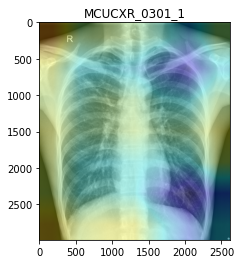

In [101]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset

pathDirData = '/home/stevenlai/Desktop/chexnet/database/'
pathFileVal = '/home/stevenlai/Desktop/chexnet/Full_set/dataset/MON_TB.txt'

# define the dataloader to load that image
datasetVal = DatasetGenerator(pathImageDirectory=pathDirData, pathDatasetFile=pathFileVal, transform=transform)
print('datasetVal:',len(datasetVal))
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=1, shuffle=False, num_workers=24, pin_memory=True)


# initialize and load in the pretrained model

pathModel = '/home/stevenlai/Desktop/chexnet/Full_set/model/2020_07_10-16:43:10_fullset.pth (copy 1).tar'
densenet = DenseNet()
modelCheckpoint = torch.load(pathModel)
densenet.load_state_dict(modelCheckpoint['state_dict'],False)

# set the evaluation mode
densenet.eval()
count = 0
for img,_ in dataLoaderVal:
    # get the image from the dataloader
    # img, _ = next(iter(dataloader))

    # get the most likely prediction of the model
    pred = densenet(img).argmax(dim=1)
    #print(pred)

    # get the gradient of the output with respect to the parameters of the model
    densenet(img)[:, 0].backward()

    # pull the gradients out of the model
    gradients = densenet.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = densenet.get_activations(img).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    #plt.matshow(heatmap.squeeze())

    img = cv2.imread('/home/stevenlai/Desktop/heatmap/test/CHNCXR_0662_1.png')
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    #cv2.imwrite('./map.jpg', superimposed_img)
    superimposed_img = superimposed_img/np.max(superimposed_img) *255
    plt.title(name[count])

    a = open(os.path.join('/home/stevenlai/Desktop/chexnet/Full_set/heatmap/MonClinicalReadings',name[count]+'.txt'))
    str_count = 0
    for line in a:
        if str_count == 2:
            #plt.text(1250,3500,str(line),ha='center',wrap=False)
            print(line)
        str_count+=1
    
    plt.imshow(superimposed_img/255)
    
    path = os.path.join('/home/stevenlai/Desktop/chexnet/Full_set/heatmap/Mon_TB',name[count])
    #plt.savefig(path)
    plt.show()
    plt.close()
    
    count += 1